In [29]:
%matplotlib widget
import sys
sys.path.append('src/')

import numpy as np
import matplotlib.pyplot as plt
import coordinates as coord 
from matplotlib import cm # for colormaps
import attitude as att # this is new!
from scipy.integrate import odeint # this is new!
import timeit 
plt.close("all")

## Useful constants

In [30]:
pi      = np.pi
deg2rad = pi / 180.0
rad2deg = 180.0 / pi

min2rad = deg2rad / 60.0
rad2min = rad2deg * 60.0

sec2rad = min2rad / 60.0
rad2sec = rad2min * 60.0

#### Converting true and eccentric anomalies ($\nu \leftrightarrow
 E$)

In [31]:
def E2nu(E, e):
    nu = np.sqrt((1 + e) / (1 - e)) 
    nu = 2 * np.arctan(nu * np.tan(E / 2))
    return nu

In [32]:
def nu2E(nu, e):
    cosnu = np.cos(nu)
    sinnu = np.sin(nu)
    sinE  = np.sqrt(1 - e * e) * sinnu / (1 + e * cosnu)
    cosE = (cosnu + e) / (1 + e * cosnu)
    E = v + np.arctan((sinE * cosnu - cosE * sinnu) / (cosE * cosnu + sinE * sinnu))

#### Solving Kepler equation in both ways ($E \leftrightarrowM 
$)

In [33]:
def E2M(E, e):
    return E - e * np.sin(E)

In [34]:
def M2E(M, e, E0):
    d   = np.array([1.0])
    eps = 1.0e-12
    E   = E0
    i = 0
    #use Newton's method
    while (d > eps).any():
        E_new = E - (E - e * np.sin(E) - M) / (1.0 - e * np.cos(E))
        d = np.abs(E_new - E)
        E = E_new
        i = i + 1
    return E, i

#### Converting true and mean anomalies ($\nu \leftrightarrowM)$

In [35]:
def nu2M(nu,e):
    E = nu2E(nu, e) # first, we compute the eccentric anomaly
    return E2M(E, e)

In [36]:
def M2nu(M,e):
    E, _ = M2E(M, e, M) # first, we compute the eccentric anomaly
    return E2nu(E, e)

## Let's test the performance of our Kepler solver starting from different initial conditions

#### First, we'll define function that measures computatation time. We make use of python lambda functions here

In [37]:
# Measure time for a piece of code to run
# lambda function introduces new extra function without defining it
time_M2E = lambda M, e, E0, number: timeit.timeit(lambda: M2E(M, e, E0), number = number)

#### Now, we run eccentric anomaly calculation for a range of mean anomalies and eccentricities

In [38]:
npts         = 200 # number of points in the grid of values
number       = 10   # for each selection of values we make a "number" of computations

# creating grid
M            = np.linspace(0.0, 360.0 * deg2rad, npts)
e            = np.linspace(0.0, 0.99, npts)
M, e         = np.meshgrid(M, e)

# creating arrays for the elapsed time and number of iterations
elapsed_time_M  = np.zeros(M.shape) # starting with E_0 = M
n_iter_M        = np.zeros(M.shape)

elapsed_time_pi = np.zeros(M.shape) # starting with E_0 = pi
n_iter_pi       = np.zeros(M.shape)

# compute mean anomaly in a loop
for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        elapsed_time_M[i,j] = time_M2E(M[i,j], e[i,j], M[i,j], number)
        _,n_iter_M[i,j]     = M2E(M[i,j], e[i,j], M[i,j])

for i in range(M.shape[0]):
    for j in range(M.shape[1]):
        elapsed_time_pi[i,j] = time_M2E(M[i,j], e[i,j], pi, number)
        _,n_iter_pi[i,j]     = M2E(M[i,j], e[i,j], pi)

## Plot the computation times

#### First, let's start iterations with E=M

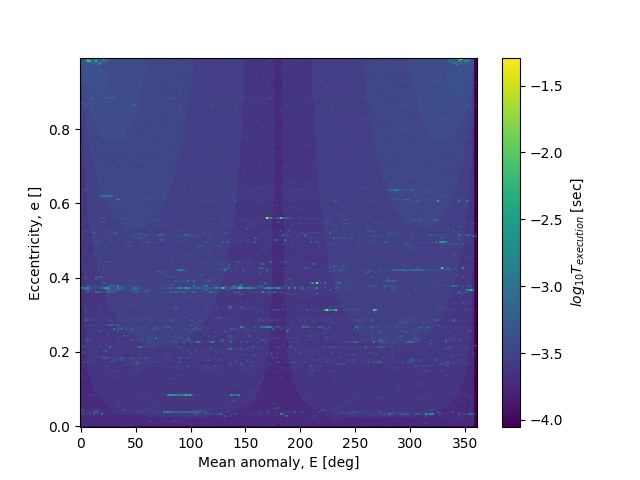

In [39]:
# staring with E_0 = M
fig = plt.figure()
plt.pcolor(M * rad2deg, e, np.log10(elapsed_time_M))
plt.xlabel("Mean anomaly, E [deg]")
plt.ylabel("Eccentricity, e []")
cbar = plt.colorbar()
cbar.set_label(r'$log_{10} T_{execution}$ [sec]')

#### Then, let's start iterations with E=$\pi$

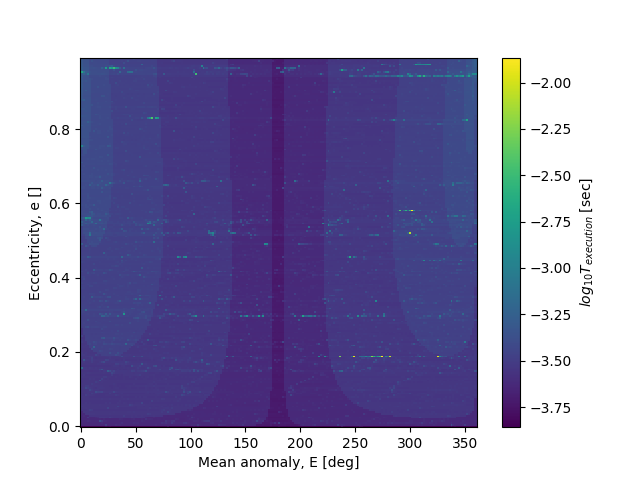

In [40]:
# starting with E_0 = pi
fig = plt.figure()
plt.pcolor(M * rad2deg, e, np.log10(elapsed_time_pi))
plt.xlabel("Mean anomaly, E [deg]")
plt.ylabel("Eccentricity, e []")
cbar = plt.colorbar()
cbar.set_label(r'$log_{10} T_{execution}$ [sec]')

#### Plot number of interations (instead of time) (starting with E=M)

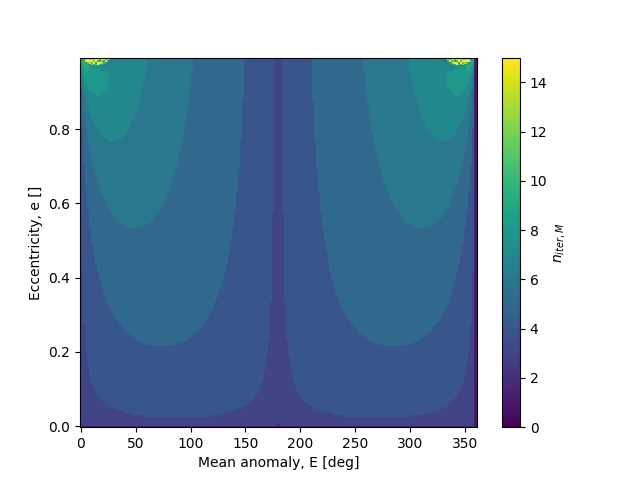

In [41]:
# starting with E_0 = M
fig = plt.figure()
plt.pcolor(M * rad2deg, e, n_iter_M)
plt.xlabel("Mean anomaly, E [deg]")
plt.ylabel("Eccentricity, e []")
cbar = plt.colorbar()
cbar.set_label(r'$n_{iter,M}$')
plt.clim((0,15))

#### Plot number of interations (starting with E=$\pi$)

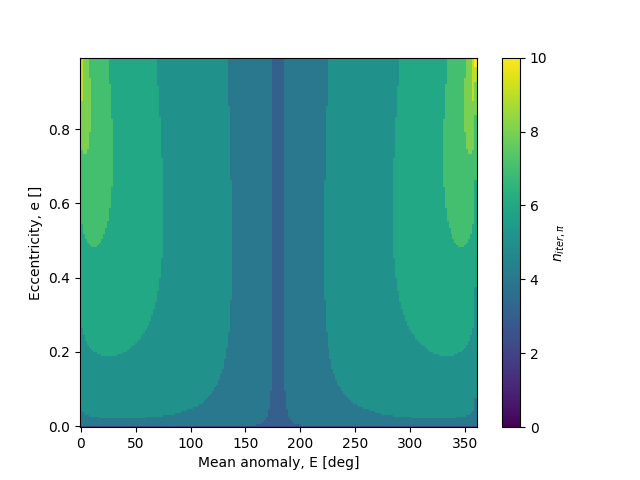

In [42]:
# starting with E_0 = pi
fig = plt.figure()
plt.pcolor(M * rad2deg, e, n_iter_pi)
plt.xlabel("Mean anomaly, E [deg]")
plt.ylabel("Eccentricity, e []")
cbar = plt.colorbar()
cbar.set_label(r'$n_{iter,\pi}$')
plt.clim((0,10))

#### Compare two starting points

Text(0, 0.5, 'Eccentricity, e []')

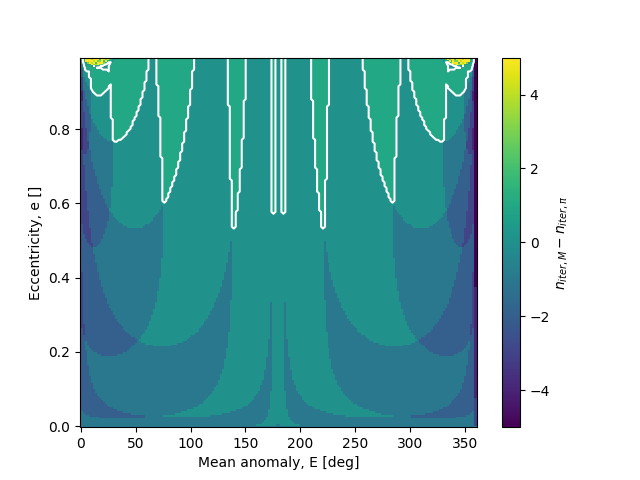

In [43]:
# Compare number of iterations.
# White contour lines indicates equal performance
fig = plt.figure()
plt.pcolor(M * rad2deg, e, n_iter_M - n_iter_pi)
cbar = plt.colorbar()
cbar.set_label(r'$n_{iter,M}-n_{iter,\pi}$')
plt.clim((-5,5))
plt.contour(M * rad2deg, e, n_iter_M - n_iter_pi,'-',levels = [0.0],colors = 'w')
plt.xlabel("Mean anomaly, E [deg]")
plt.ylabel("Eccentricity, e []")

## Finally, let's see how true anomaly changes as a function of the mean anomaly (or effectively as a function of time) and eccentricity

In [44]:
# compute true anomalies for a range of eccentricity
npts_M = 1000
npts_e = 10

# grid of values
M  = np.linspace(0.0, 360.0 * deg2rad, npts_M)
e  = np.linspace(1e-4, 0.9, npts_e)
nu = np.zeros((M.shape[0],e.shape[0]))

# compute true anomaly from the mean anomaly
for i in range(npts_e):
    nu[:,i] = M2nu(M,e[i])

nu[nu < 0] = nu[nu < 0] + 2*pi

Text(0, 0.5, 'True anomaly [deg]')

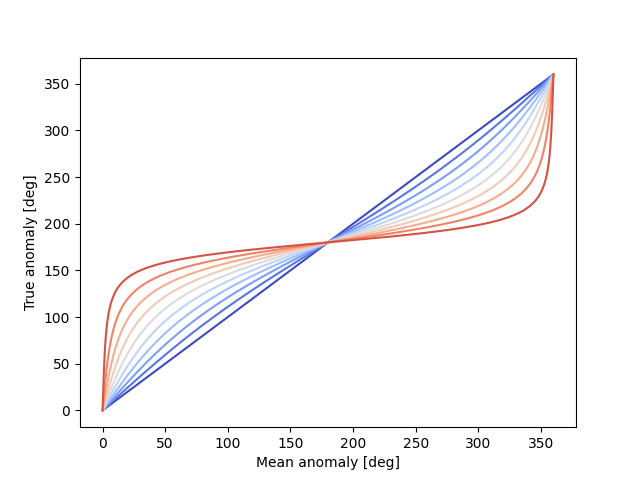

In [45]:
plt.figure()
cmap = plt.colormaps.get_cmap('coolwarm')
for i in range(npts_e):
    scaled_color = cmap(e[i])
    plt.plot(M * rad2deg,nu[:,i] * rad2deg,'-', color = scaled_color)

plt.xlabel("Mean anomaly [deg]")
plt.ylabel("True anomaly [deg]")

Text(0, 0.5, '$M-\\nu$ [difference in angles]')

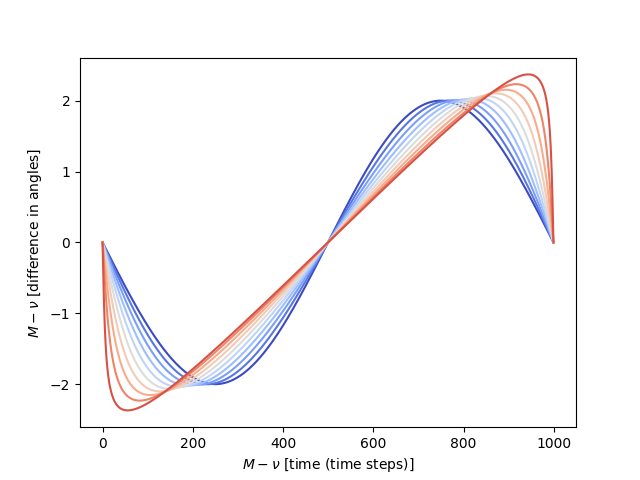

In [46]:
plt.figure()
cmap = plt.colormaps.get_cmap('coolwarm')
for i in range(npts_e):
    scaled_color = cmap(e[i])
    plt.plot((M - nu[:,i])/e[i],'-', color = scaled_color)

plt.xlabel(r"$M-\nu$ [time (time steps)]")
plt.ylabel(r"$M-\nu$ [difference in angles]")

For small e, max(|M - $\nu$|) = 2e

## Below is an efficient way for solving the incremental Kepler equation. We did not discuss it in the class. It is useful for implementing "Kepler advancer", which is a part of certain orbital integrators

In [47]:
def IncrementalEccFunc(dE, ecosE, esinE, dM):
    return dE + (1 - np.cos(dE)) * esinE - np.sin(dE) * ecosE - dM

In [48]:
def dM2dE(dM, ecosE, esinE):
    d   = 1.0
    eps = 1.0e-12
    dE  = dM
    
    while (d > eps):
        dE1 = dE
        f = IncrementalEccFunc(dE, ecosE, esinE, dM)

        fd   = 1 - ecosE * np.cos(dE) + esinE * np.sin(dE)
        fdd  = esinE * np.cos(dE) + ecosE * np.sin(dE)
        fddd = ecosE * np.cos(dE) - esinE * np.sin(dE)

        Delta =- f/fd;
        Delta =- f/(fd+fdd*Delta/2.0);
        Delta =- f/(fd+fdd*Delta/2.0+fddd*Delta*Delta/6.0)

        dE = dE + Delta
        d  = np.abs(dE1-dE)
    return dE

In [49]:
time_dM2dE = lambda dMi, ecosEi, esinEi, number: timeit.timeit(lambda: dM2dE(dMi, ecosEi, esinEi), number = number)

dM           = 0.01
npts         = 100
number       = 10
E            = np.linspace(0.00, 360.0 * deg2rad, npts)
e            = np.linspace(0.00, 0.95, npts)
E, e         = np.meshgrid(E, e)
elapsed_time = np.zeros(E.shape)

for i in range(E.shape[0]):
    for j in range(E.shape[1]):
        ecosE             = e[i,j] * np.cos(E[i,j])
        esinE             = e[i,j] * np.sin(E[i,j])
        elapsed_time[i,j] = time_dM2dE(dM, ecosE, esinE, number)

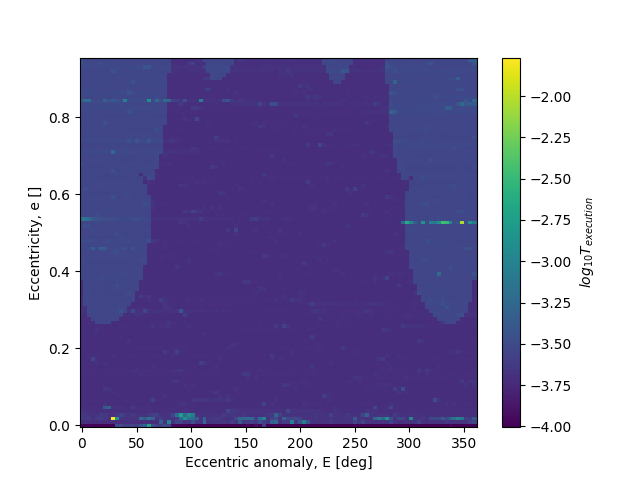

In [50]:
fig = plt.figure()
plt.pcolor(E * rad2deg, e, np.log10(elapsed_time))
plt.xlabel("Eccentric anomaly, E [deg]")
plt.ylabel("Eccentricity, e []")
cbar = plt.colorbar()
cbar.set_label(r'$log_{10} T_{execution}$')